In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

In [10]:
local_dir = os.getcwd()
#data_path = COSTUM_DATA_LOCATION
#model_path = COSTUM_MODEL_LOCATION
data_path = os.path.join(os.path.dirname(os.path.dirname(local_dir)),'data')
model_path = os.path.join(os.path.dirname(local_dir),'models')

In [11]:
df = pd.read_csv(os.path.join(data_path,"train_preprocessed.csv"), index_col=[0])

In [12]:
# For final analysis below (not used for Chi-square)
X = df.loc[:, df.columns != 'SUSPECT_RACE_DESCRIPTION']
y = df.loc[:, 'SUSPECT_RACE_DESCRIPTION']

X.drop(['SUSPECT_REPORTED_AGE_CUT'], axis=1)

,STOP_ID,STOP_FRISK_DATE,STOP_FRISK_TIME,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,...,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME,IMMEDIATE_STOP_FLAG,STOP_FRISK_TIME_HOUR,KMEANS_DEMEANOR,TIME_NUM
0,1966,2020-02-27,22:50:00,2020,February,Thursday,Based on Self Initiated,APP,POM,807,...,E 144 ST,1007418,234886,10454,PBBX,BRONX,N,22,0,22.833333
1,6248,2020-08-04,08:41:00,2020,August,Tuesday,Based on Radio Run,APP,POF,863,...,E 14 ST,987034,206937,unknown,PBMS,MANHATTAN,Y,8,0,8.683333
2,7302,2020-09-28,11:23:00,2020,September,Monday,Based on C/W on Scene,APP,OTHER,104,...,FOREST AVE,1012514,194041,11385,PBQN,QUEENS,Y,11,1,11.383333
3,1310,2020-02-05,09:45:00,2020,February,Wednesday,Based on Radio Run,APP,POM,121,...,RILEY PL,945306,168366,10302,PBSI,STATEN ISLAND,Y,9,0,9.750000
4,3959,2020-04-29,02:45:00,2020,April,Wednesday,Based on Self Initiated,APP,POM,72,...,3 AVE,978428,173195,11220,PBBS,BROOKLYN,Y,2,0,2.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,7527,2020-10-08,19:01:00,2020,October,Thursday,Based on C/W on Scene,APP,POM,43,...,PUGSLEY AVENUE,1020316,239179,unknown,PBBX,BRONX,N,19,0,19.016667
7631,6472,2020-08-10,16:30:00,2020,August,Monday,Based on C/W on Scene,APP,POM,52,...,E 196 ST,1014349,255237,10458,PBBX,BRONX,N,16,0,16.500000
7632,2455,2020-02-06,16:04:00,2020,February,Thursday,Based on Radio Run,APP,SGT,49,...,PELHAM PARKWAY NORTH,1027294,251236,unknown,PBBX,BRONX,Y,16,2,16.066667
7633,9485,2020-12-11,23:21:00,2020,December,Friday,Based on Self Initiated,APP,POM,75,...,ATLANTIC AVE,1004073,186073,11233,PBBN,BROOKLYN,N,23,6,23.350000


# 1. Categorical Feature Selection

In [13]:
#Troba les columnes categòriques
cat_col = []
num_col = []
for i in df.columns:
    if df[i].dtype == 'object':
        cat_col.append(i)
    elif df[i].dtype == 'int64':
        num_col.append(i)

In [14]:
from scipy.stats import chi2_contingency
chi2_check = []
pvalues = []
for i in cat_col:
    pval = chi2_contingency(pd.crosstab(df['SUSPECT_RACE_DESCRIPTION'], df[i]))[1]
    if chi2_contingency(pd.crosstab(df['SUSPECT_RACE_DESCRIPTION'], df[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
        pvalues.append(pval)
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
        pvalues.append(pval)
res = pd.DataFrame(data = [cat_col, chi2_check, pvalues] 
             ).T 
res.columns = ['Column', 'Hypothesis', 'p-value']
print(res)

                            Column                      Hypothesis   p-value
0                  STOP_FRISK_DATE          Reject Null Hypothesis       0.0
1                  STOP_FRISK_TIME          Reject Null Hypothesis       0.0
2                           MONTH2          Reject Null Hypothesis  0.004808
3                             DAY2  Fail to Reject Null Hypothesis  0.402527
4               STOP_WAS_INITIATED          Reject Null Hypothesis  0.011268
..                             ...                             ...       ...
61          STOP_LOCATION_ZIP_CODE          Reject Null Hypothesis       0.0
62  STOP_LOCATION_PATROL_BORO_NAME          Reject Null Hypothesis       0.0
63         STOP_LOCATION_BORO_NAME          Reject Null Hypothesis       0.0
64             IMMEDIATE_STOP_FLAG  Fail to Reject Null Hypothesis  0.105606
65        SUSPECT_REPORTED_AGE_CUT          Reject Null Hypothesis       0.0

[66 rows x 3 columns]


In [15]:
#Output features

final = res.loc[res["Hypothesis"] == "Reject Null Hypothesis"]
final = final.sort_values(by=['p-value'])

final.to_csv(os.path.join(data_path,'feature_categorical.txt'), sep='\t', index=False)
res = res.sort_values(by=['p-value'])
res.to_csv(os.path.join(data_path,'allfeatures.txt'),sep='\t', index=False)


In [16]:
notfinal = res.loc[res["Hypothesis"] == "Fail to Reject Null Hypothesis"]
notfinal.sort_values(by=['p-value'])

,Column,Hypothesis,p-value
42,SUSPECTS_ACTIONS_LOOKOUT_FLAG,Fail to Reject Null Hypothesis,0.059569
21,CONSENT_GIVEN_FLG,Fail to Reject Null Hypothesis,0.068843
20,ASK_FOR_CONSENT_FLG,Fail to Reject Null Hypothesis,0.085492
10,OTHER_PERSON_STOPPED_FLAG,Fail to Reject Null Hypothesis,0.096336
13,SUMMONS_ISSUED_FLAG,Fail to Reject Null Hypothesis,0.101846
64,IMMEDIATE_STOP_FLAG,Fail to Reject Null Hypothesis,0.105606
43,SUSPECTS_ACTIONS_OTHER_FLAG,Fail to Reject Null Hypothesis,0.111938
28,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,Fail to Reject Null Hypothesis,0.157411
40,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,Fail to Reject Null Hypothesis,0.179269
16,SHIELD_IDENTIFIES_OFFICER_FLAG,Fail to Reject Null Hypothesis,0.179269


# 2. Categorical features by levels

In [17]:
check = {}
pvalues = []

for i in res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']:
    dummies = pd.get_dummies(df[i])
    bon_p_value = 0.05/df[i].nunique()
    for series in dummies:
        pval = chi2_contingency(pd.crosstab(df['SUSPECT_RACE_DESCRIPTION'], dummies[series]))[1]
        pvalues.append(pval)
        if pval < bon_p_value:
            check['{}-{}'.format(i, series)] = 'Reject Null Hypothesis'
        else:
            check['{}-{}'.format(i, series)] = 'Fail to Reject Null Hypothesis'
res_chi_ph = pd.DataFrame(data = [check.keys(), check.values(), pvalues]).T
res_chi_ph.columns = ['Pair', 'Hypothesis', 'P-value']
res_chi_ph


,Pair,Hypothesis,P-value
0,SUSPECT_RACE_DESCRIPTION-BLACK,Reject Null Hypothesis,0.0
1,SUSPECT_RACE_DESCRIPTION-OTHER,Reject Null Hypothesis,0.0
2,SUSPECT_RACE_DESCRIPTION-WHITE,Reject Null Hypothesis,0.0
3,STOP_LOCATION_ZIP_CODE-10000,Fail to Reject Null Hypothesis,0.756638
4,STOP_LOCATION_ZIP_CODE-10001,Fail to Reject Null Hypothesis,0.354373
...,...,...,...
9761,SUSPECT_SEX-unknown,Fail to Reject Null Hypothesis,0.418038
9762,OTHER_CONTRABAND_FLAG-N,Fail to Reject Null Hypothesis,0.035575
9763,OTHER_CONTRABAND_FLAG-Y,Fail to Reject Null Hypothesis,0.035575
9764,SEARCH_BASIS_CONSENT_FLAG-N,Fail to Reject Null Hypothesis,0.03849


In [18]:
res_chi_ph = pd.DataFrame(data = [check.keys(), check.values(), pvalues]).T
res_chi_ph.columns = ['Pair', 'Hypothesis', 'P-value']
res_chi_ph

res_chi_ph.to_csv(os.path.join(data_path,'features_categorical_bylevels.txt'), sep='\t', index=False)


In [19]:
chi2_check = []
pvalues = []
for i in num_col:
    pval = chi2_contingency(pd.crosstab(df['SUSPECT_RACE_DESCRIPTION'], df[i]))[1]
    if chi2_contingency(pd.crosstab(df['SUSPECT_RACE_DESCRIPTION'], df[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
        pvalues.append(pval)
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
        pvalues.append(pval)
res = pd.DataFrame(data = [num_col, chi2_check, pvalues] 
             ).T 
res.columns = ['Column', 'Hypothesis', 'p-value']
print(res)

                              Column                      Hypothesis   p-value
0                            STOP_ID  Fail to Reject Null Hypothesis  0.493886
1                              YEAR2  Fail to Reject Null Hypothesis       1.0
2       ISSUING_OFFICER_COMMAND_CODE          Reject Null Hypothesis       0.0
3   SUPERVISING_OFFICER_COMMAND_CODE          Reject Null Hypothesis       0.0
4              STOP_DURATION_MINUTES          Reject Null Hypothesis       0.0
5               SUSPECT_REPORTED_AGE          Reject Null Hypothesis       0.0
6                     SUSPECT_WEIGHT  Fail to Reject Null Hypothesis  0.555954
7             STOP_LOCATION_PRECINCT          Reject Null Hypothesis       0.0
8                    STOP_LOCATION_X          Reject Null Hypothesis       0.0
9                    STOP_LOCATION_Y          Reject Null Hypothesis       0.0
10              STOP_FRISK_TIME_HOUR          Reject Null Hypothesis   0.00299
11                   KMEANS_DEMEANOR          Reject

In [29]:
res.to_csv(os.path.join(data_path,'numerical_chi.txt'), sep='\t', index=False)

In [21]:
from scipy import stats

corr = []
for i in num_col:
        cor = df[i].corr(df['SUSPECT_RACE_DESCRIPTION'], method='kendall')
        corr.append(cor)
    
res = pd.DataFrame(data = [num_col, corr] 
             ).T 
res.columns = ['Column', 'Kendall Correlation']
print(res)


                              Column Kendall Correlation
0                            STOP_ID            0.023644
1                              YEAR2                 NaN
2       ISSUING_OFFICER_COMMAND_CODE           -0.016283
3   SUPERVISING_OFFICER_COMMAND_CODE           -0.018992
4              STOP_DURATION_MINUTES             0.07576
5               SUSPECT_REPORTED_AGE            0.088805
6                     SUSPECT_WEIGHT           -0.041534
7             STOP_LOCATION_PRECINCT            0.055815
8                    STOP_LOCATION_X           -0.048062
9                    STOP_LOCATION_Y           -0.012682
10              STOP_FRISK_TIME_HOUR           -0.030554
11                   KMEANS_DEMEANOR            0.027151


In [27]:
res.to_csv(os.path.join(data_path,'numerical_kendall.txt'), sep='\t', index=False)

In [23]:
from scipy.stats import chi2_contingency
X['KMEANS_DEMEANOR'] = pd.Categorical(X.KMEANS_DEMEANOR)
chi_res = chi2_contingency(pd.crosstab(y, X['KMEANS_DEMEANOR']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 105.45135070117915, p-value: 1.3161809432020692e-13


C:\Users\louis\AppData\Local\Temp\ipykernel_16372\3995442809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['KMEANS_DEMEANOR'] = pd.Categorical(X.KMEANS_DEMEANOR)


In [24]:
# Removal of chi-square2 not approved columns
cat_col = [
'SUSPECT_HAIR_COLOR',
'STOP_LOCATION_PATROL_BORO_NAME',	
'SUSPECT_EYE_COLOR',	
'STOP_LOCATION_BORO_NAME',	
'SUSPECTED_CRIME_DESCRIPTION',	
'FRISKED_FLAG',
'SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG',	
'SUSPECT_ARREST_OFFENSE',	
'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG',	
'FIREARM_FLAG',
'SUSPECT_BODY_BUILD_TYPE',
'BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG',	
'OTHER_WEAPON_FLAG',
'WEAPON_FOUND_FLAG',
'VERBAL_IDENTIFIES_OFFICER_FLAG',	
'SUSPECTS_ACTIONS_CASING_FLAG',	
'SUPERVISING_OFFICER_RANK',
'DEMEANOR_CODE',	
'MONTH2',
'OFFICER_IN_UNIFORM_FLAG',	
'SUSPECT_ARRESTED_FLAG',	
'STOP_WAS_INITIATED',
'SEARCH_BASIS_HARD_OBJECT_FLAG',
'SEARCHED_FLAG',	
'SUSPECT_SEX',	
'OTHER_CONTRABAND_FLAG',	
'SEARCH_BASIS_CONSENT_FLAG', 'KMEANS_DEMEANOR']


X_subset = X[df.columns.intersection(cat_col)]

 # 3. Feature Selection using Extra Trees Classifier

[1.17229914e-02 7.84862300e-03 1.01808258e-02 1.30644857e-02
 1.36384646e-02 7.80706069e-03 9.08857546e-03 1.33205324e-02
 1.44746238e-02 1.09801132e-02 1.02308730e-02 9.69972947e-03
 1.14743821e-02 1.53510089e-02 1.02634737e-02 1.35201881e-02
 3.36657690e-03 1.44158098e-02 1.04952315e-02 2.17247846e-03
 1.10315881e-02 1.84494242e-03 1.16295504e-02 4.16399353e-03
 6.58960180e-04 1.17932854e-04 1.15777351e-03 1.05201786e-03
 3.61350019e-04 3.94536492e-03 5.21444894e-04 5.13495388e-03
 6.32755499e-03 2.11353875e-03 4.05870144e-03 1.40812502e-03
 6.47086500e-03 9.51678817e-03 6.70170523e-06 3.75201516e-04
 1.65229153e-03 1.05335639e-02 1.50892506e-04 1.61684639e-04
 2.37546902e-03 9.03941613e-03 9.02789217e-03 4.44353900e-03
 2.53611512e-04 3.25259374e-03 1.42087450e-03 3.16463331e-03
 2.48744894e-03 1.21029324e-03 5.22355621e-05 4.79266239e-05
 1.04119625e-04 2.51443935e-03 1.38550935e-04 2.09760934e-03
 1.42380335e-03 5.90490443e-04 1.69704330e-03 2.74317919e-04
 3.66438545e-03 4.362782

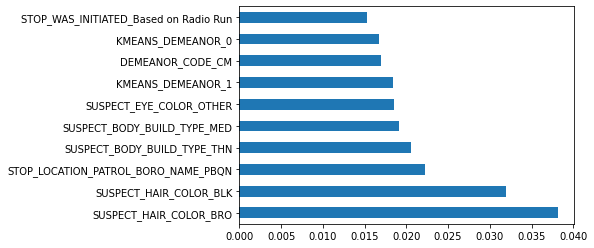

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
X = pd.get_dummies(X_subset)
y = pd.get_dummies(y)
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

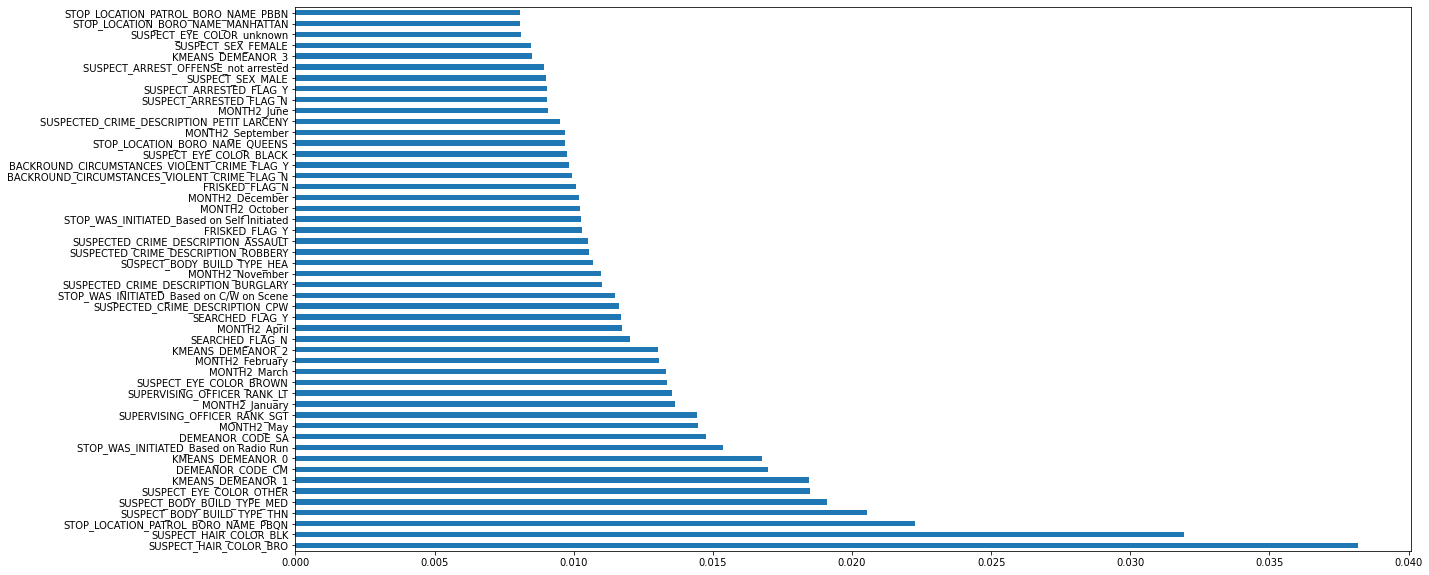

In [26]:
feat_importances.nlargest(50).plot(kind='barh', figsize=(20,10))
plt.show()